# Setup
## Install necessary libs (Now skipped as GPU activated)

In [13]:
!pip install tensorflow
!pip install opencv-python
!pip install scikit-learn
!pip install numpy
!pip install pandas
!pip install pympler
!pip install matplotlib
!pip install scikeras

ERROR: Invalid requirement: '=='


# Import libs

In [1]:

import tensorflow as tf
# import cv2
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

In [1]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict



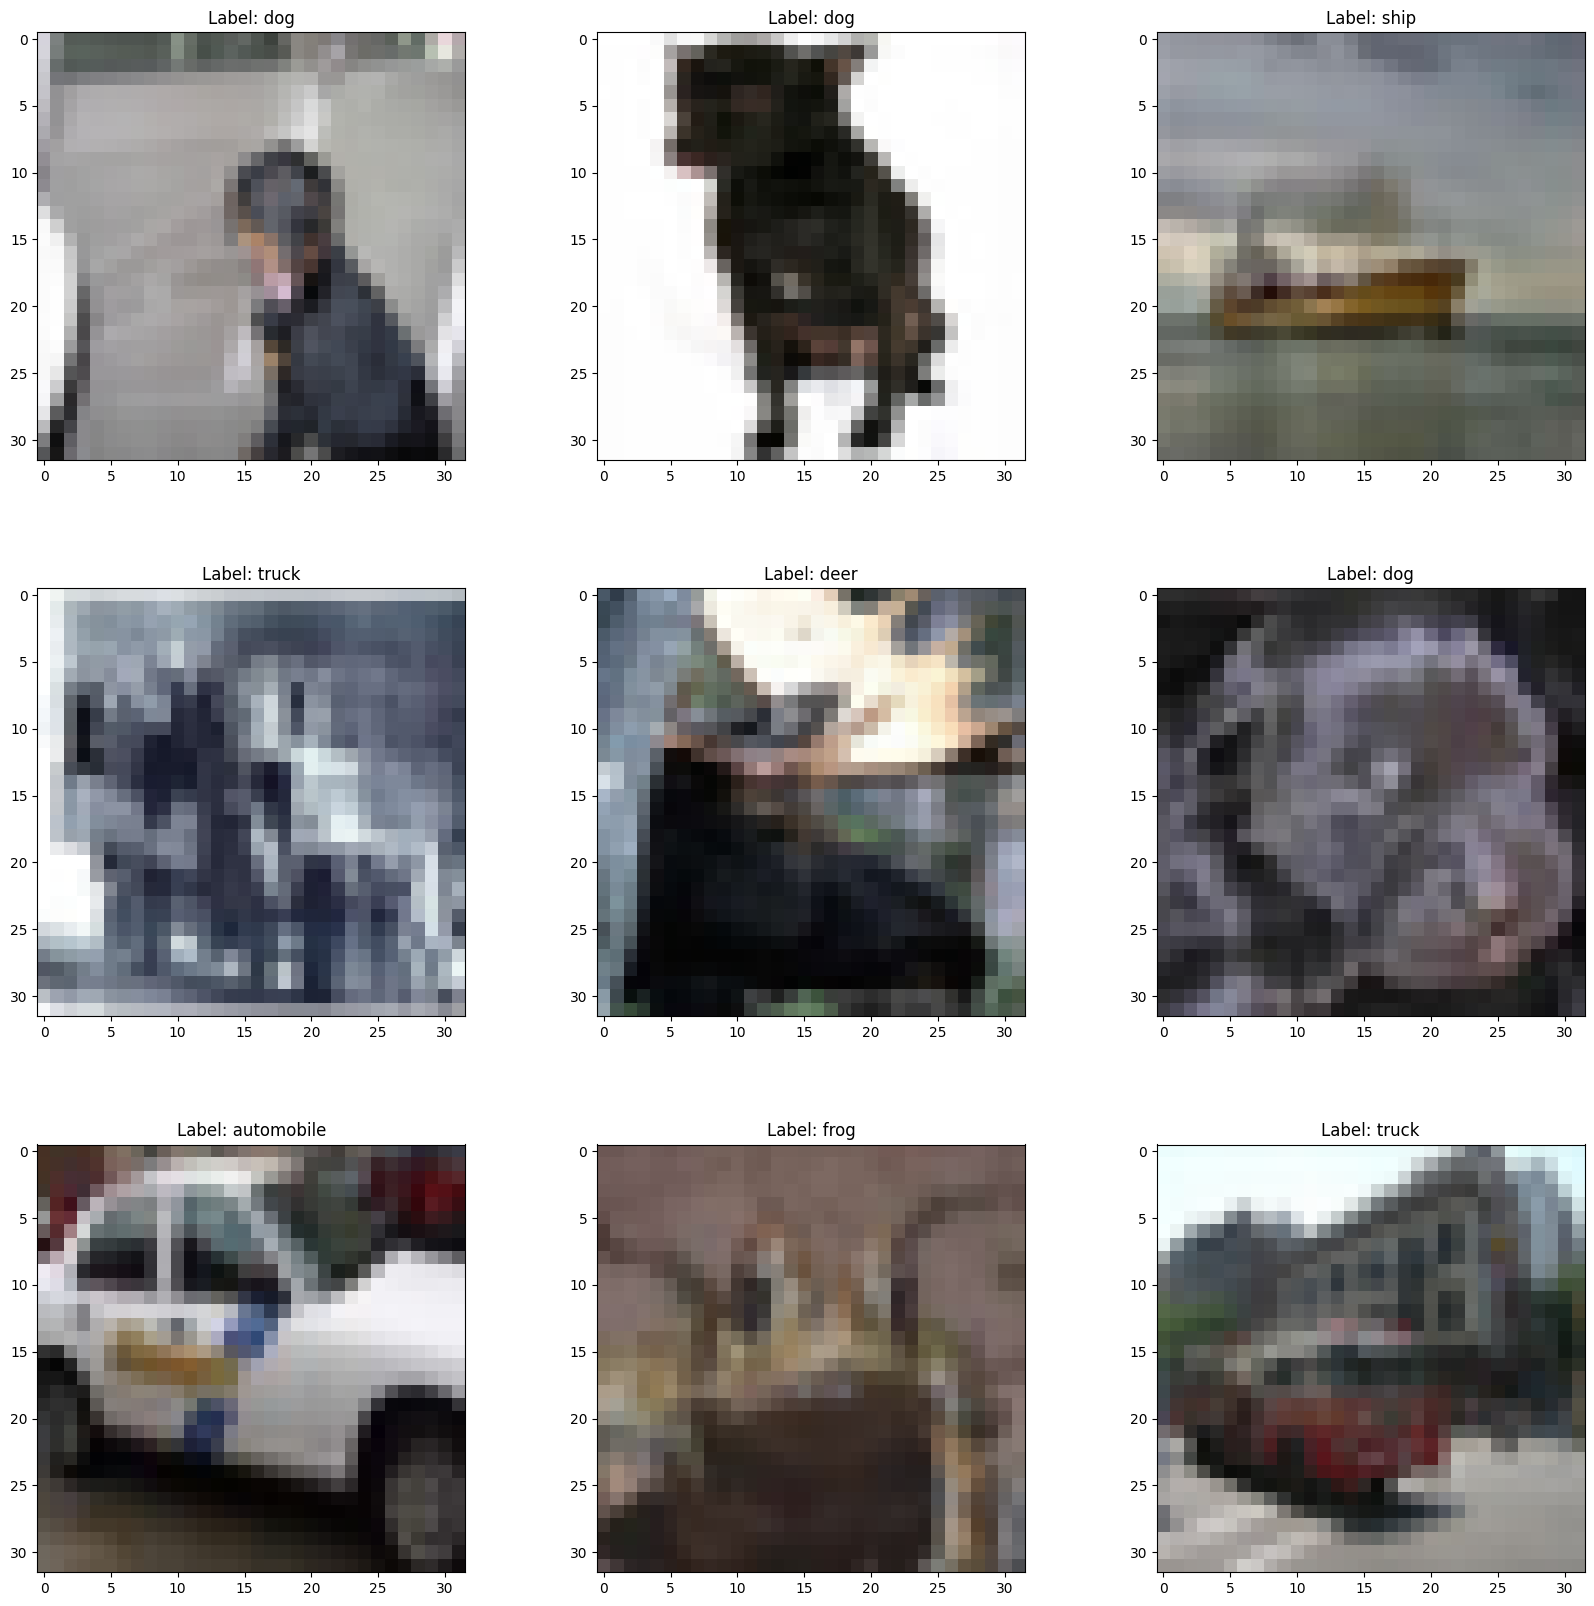

In [3]:
def display_images(batch, metadata):
    batch_images = batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    labels =  pd.DataFrame({"name": metadata[b'label_names'], 
              "id": [i for i in range(len(metadata[b'label_names']))]}).set_index('id')

    num_img = 9

    fig, axes = plt.subplots(3, 3, figsize=(20,20))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i in range(num_img):
        idx = np.random.randint(metadata[b'num_cases_per_batch'])
        ax = axes[i // 3, i % 3]
        ax.imshow(batch_images[idx])
        ax.set_title(f"Label: {labels.loc[batch[b'labels'][idx]].values[0].decode('ascii')}")
    plt.show()

display_images(unpickle("../data/data_batch_1"),unpickle("../data/batches.meta"))

## Quick EDA (Repartition of classes, etc...)

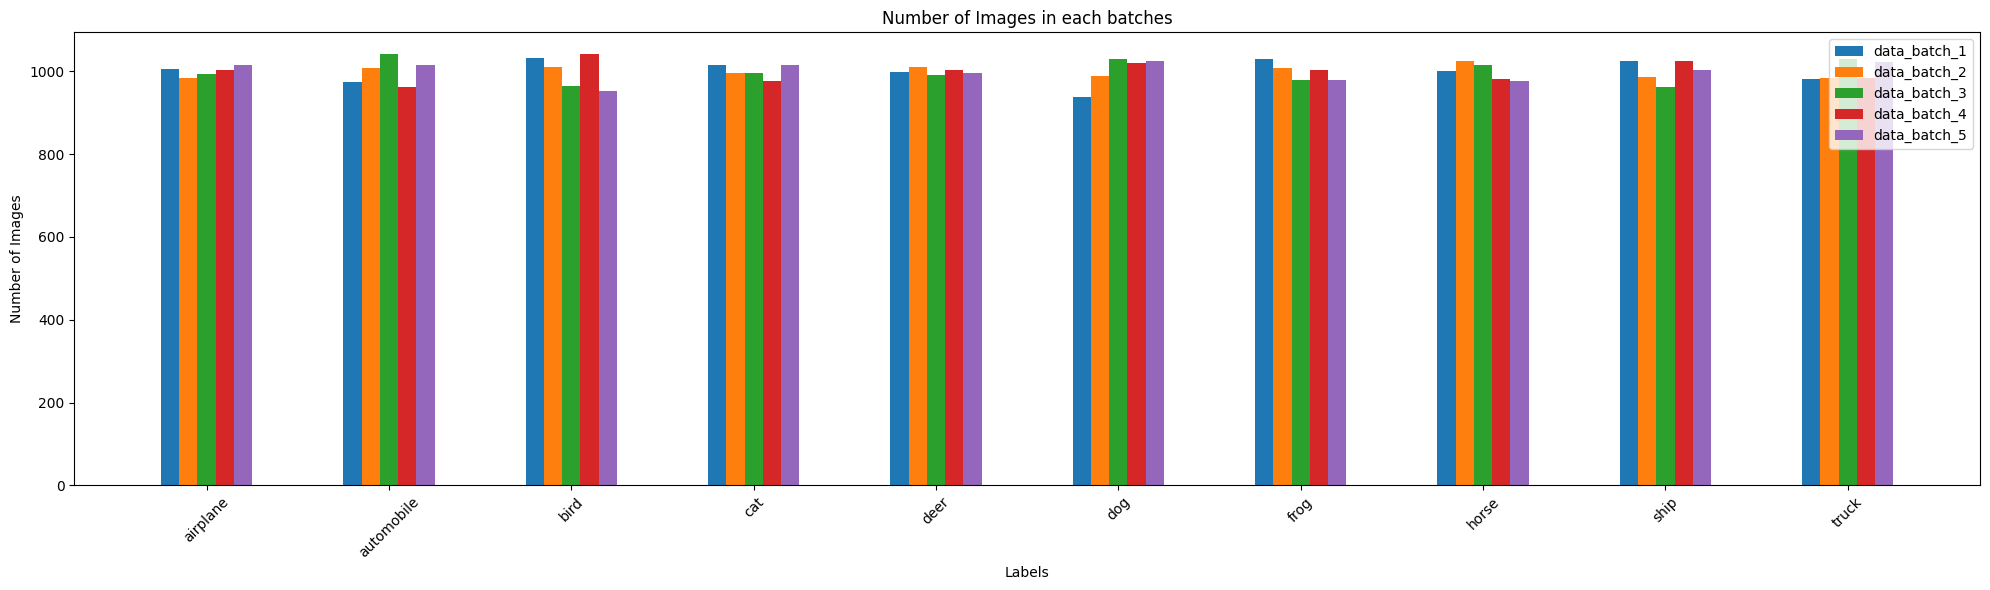

In [47]:
labels = pd.DataFrame({"name": [ i.decode('ascii') for i in meta[b'label_names']], 
            "id": [i for i in range(len(meta[b'label_names']))]})

def compute_batch_repartition(batch, name):
    l = batch[b'labels']
    lc  = [0 for i in range(10)]
    for i in l:
        lc[i] += 1
    return {"name": name, "distribution": lc}

batches_path = ["../data/data_batch_1","../data/data_batch_2","../data/data_batch_3","../data/data_batch_4","../data/data_batch_5"]
batches_distrib = [compute_batch_repartition(unpickle(i), i.split("/")[-1]) for i in batches_path]

plt.figure(figsize=(20,6))
X = labels["name"]
bar_width = 0.1
xaxis = np.arange(len(X))

for i in range(len(batches_distrib)):
    x = xaxis + i * bar_width
    plt.bar(x, batches_distrib[i]['distribution'], bar_width, label = batches_distrib[i]['name'])

plt.xticks(xaxis + bar_width * (len(batches_distrib) - 1) / 2, X, rotation=45)
plt.xlabel("Labels")
plt.ylabel("Number of Images")
plt.title("Number of Images in each batches")
plt.legend()
plt.tight_layout()
plt.show()


We can obersve difference, we might want to 

## Preprocess

In [2]:
batches_path = ["../data/data_batch_1","../data/data_batch_2","../data/data_batch_3","../data/data_batch_4","../data/data_batch_5"]

def simple_preprocess(unpickled_batch):
    # This shape is given by cifar dataset
    unpickled_batch[b'data'] = unpickled_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    return unpickled_batch

def simple_preprocess_xy(unpickled_batch):
    unpickled_batch[b'data'] = unpickled_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    return tf.convert_to_tensor(unpickled_batch[b'data']), tf.convert_to_tensor(unpickled_batch[b'labels']) 

def get_all_batches_all():
    X = []
    Y = []
    for i in batches_path:
        batch = unpickle(i)
        batch[b'data'] = batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        X.append(batch[b'data'])
        Y.append(batch[b'labels'])
    X = np.array(X)
    Y = np.array(Y)
    return X.reshape(X.shape[0]*X.shape[1], X.shape[2], X.shape[3], X.shape[4]), Y.reshape(X.shape[0]*X.shape[1])


## Training

Display the first model I'm starting with to display how well it perform (Ran once and let to display)

In [11]:
from tensorflow.keras import layers

def create_model():
        
    input_shape = (32, 32, 3)
    num_classes = 10

    model = tf.keras.Sequential(
        [
            layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
            layers.MaxPooling2D((2,2)),
            layers.Conv2D(64, (3,3), activation='relu'),
            layers.MaxPooling2D((2,2)),
            layers.Conv2D(128, (3,3), activation='relu'),
            layers.MaxPooling2D((2,2)),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation='softmax')
        ]
    )
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model


def training_loop(model):
    x,y = simple_preprocess_xy(unpickle(batches_path[0]))
    model.fit(x,y, batch_size=32, epochs=10)
    # for i in batches_path:
    #     b = simple_preprocess(unpickle(i))
    #     x = tf.convert_to_tensor(b[b'data'])
    #     y = tf.convert_to_tensor(b[b'labels'])
    #     model.fit(x,y, batch_size=32, epochs=10)


model = create_model()
training_loop(model)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.1937 - loss: 3.1302
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3786 - loss: 1.7026
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4379 - loss: 1.5583
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4936 - loss: 1.3969
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5391 - loss: 1.2821
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5711 - loss: 1.2121
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6190 - loss: 1.0732
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6406 - loss: 0.9989
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6780 - loss: 0.9239
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7058 - loss: 0.8221


## Dev and test 

In [5]:
def test(model):
    x, y = simple_preprocess_xy(unpickle("../data/test_batch"))
    loss = model.evaluate(x,y)
    return loss
loss = test(model)
loss

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5002 - loss: 1.3900


[1.3847118616104126, 0.5058000087738037]

## Fine-tune & Analysis

### Try different archs

In [4]:
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, log_loss


def display_metrics(accs, losses, y_true, y_predicted, labels):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))
    display_loss_graph(accs, losses, ax1, ax2)
    display_confusion_matrix(y_true, y_predicted, ax3, labels)
    tets_str = "Yes" #TODO: Change
    fig.suptitle(f"Metrics for {tets_str}")
    plt.show()

def display_loss_graph(accs, losses, ax1, ax2):
    l = list(range(len(accs['train'])))
    ax1.plot(l, accs['train'])
    ax1.plot(l, accs['val'])
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")
    ax1.legend(["Train","Dev"])
    ax1.set_title("Accuracy evolution")

    ax2.plot(l, losses['train'])
    ax2.plot(l, losses['val'])
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.legend(["Train","Dev"])
    ax2.set_title("Loss evolution")

def display_confusion_matrix(y_true, y_pred, ax, labels):
    cm = confusion_matrix(y_true, y_pred)
    cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    cm.plot(ax=ax, xticks_rotation=50)

In [7]:
from tensorflow.keras import layers

def model_tuning_cr():
    
    input_shape = (32, 32, 3)
    num_classes = 10

    convlayers_params = {
        # 'filters': [32, 64, 128, 256],
        'filters': [32, 128, 256, 256],
        'kernel_size': [(3,3),(3,3),(3,3),(3,3)],
    } 
    
    # regularizer = tf.keras.regularizers.l2(l2=0.15)
    regularizer = tf.keras.regularizers.l2(l2=0.01)
    model = tf.keras.Sequential(
        [
            layers.Input(shape=input_shape),
            layers.Conv2D(convlayers_params['filters'][0], convlayers_params['kernel_size'][0], activation='relu', use_bias=True, kernel_regularizer=regularizer),
            layers.MaxPooling2D((2,2)),
            layers.BatchNormalization(),
            layers.Conv2D(convlayers_params['filters'][1], convlayers_params['kernel_size'][1], activation='relu',use_bias=True,  kernel_regularizer=regularizer),
            layers.MaxPooling2D((2,2)),
            layers.BatchNormalization(),
            layers.Conv2D(convlayers_params['filters'][2], convlayers_params['kernel_size'][2], activation='relu', use_bias=True, kernel_regularizer=regularizer),
            layers.BatchNormalization(),
            layers.Conv2D(convlayers_params['filters'][3], convlayers_params['kernel_size'][3], activation='relu', use_bias=True, kernel_regularizer=regularizer),
            layers.MaxPooling2D((2,2)),
            layers.Flatten(),
            layers.Dense(128, activation='relu', use_bias=True, kernel_regularizer=regularizer),
            layers.Dropout(0.25),
            layers.Dense(num_classes, activation='softmax')
        ]
    )
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model


model = model_tuning_cr()
X, Y = get_all_batches_all()
history = model.fit(X,Y, batch_size=256, epochs=200, validation_split=.2, verbose=1)


Epoch 1/200
157/157 [==============================] - 5s 21ms/step - loss: 5.1562 - accuracy: 0.4757 - val_loss: 3.2403 - val_accuracy: 0.4411
Epoch 2/200
157/157 [==============================] - 3s 19ms/step - loss: 2.0872 - accuracy: 0.6284 - val_loss: 2.1273 - val_accuracy: 0.5091
Epoch 3/200
157/157 [==============================] - 3s 19ms/step - loss: 1.5100 - accuracy: 0.6811 - val_loss: 1.5174 - val_accuracy: 0.6489
Epoch 4/200
157/157 [==============================] - 3s 19ms/step - loss: 1.3377 - accuracy: 0.7156 - val_loss: 1.5553 - val_accuracy: 0.6384
Epoch 5/200
157/157 [==============================] - 3s 19ms/step - loss: 1.3000 - accuracy: 0.7354 - val_loss: 1.6200 - val_accuracy: 0.6371
Epoch 6/200
157/157 [==============================] - 3s 19ms/step - loss: 1.2827 - accuracy: 0.7455 - val_loss: 1.5020 - val_accuracy: 0.6737
Epoch 7/200
157/157 [==============================] - 3s 19ms/step - loss: 1.2653 - accuracy: 0.7590 - val_loss: 1.5079 - val_accuracy:

In [8]:
train_loss = history.history['loss'] 
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
acc = {"train": np.array(train_acc).flatten(), "val": np.array(val_acc).flatten()}
losses = {"train": np.array(train_loss).flatten(), "val": np.array(val_loss).flatten()}

print(f"Max acc - train: {np.max(acc['train'])}, val: {np.max(acc['val'])}")
meta = unpickle("../data/batches.meta")
labels = pd.DataFrame({"name": [ i.decode('ascii') for i in meta[b'label_names']], 
            "id": [i for i in range(len(meta[b'label_names']))]})

x_test, y_test = simple_preprocess_xy(unpickle("../data/test_batch"))
y_predicted = model.predict(x_test,verbose=0)
y_predicted =  np.argmax(np.array(y_predicted), axis=1)

display_metrics(acc, losses, y_test, y_predicted, labels['name'])

Max acc - train: 0.8973249793052673, val: 0.7717000246047974


NameError: name 'pd' is not defined

Max acc - train: 0.9446750283241272, val: 0.7495999932289124


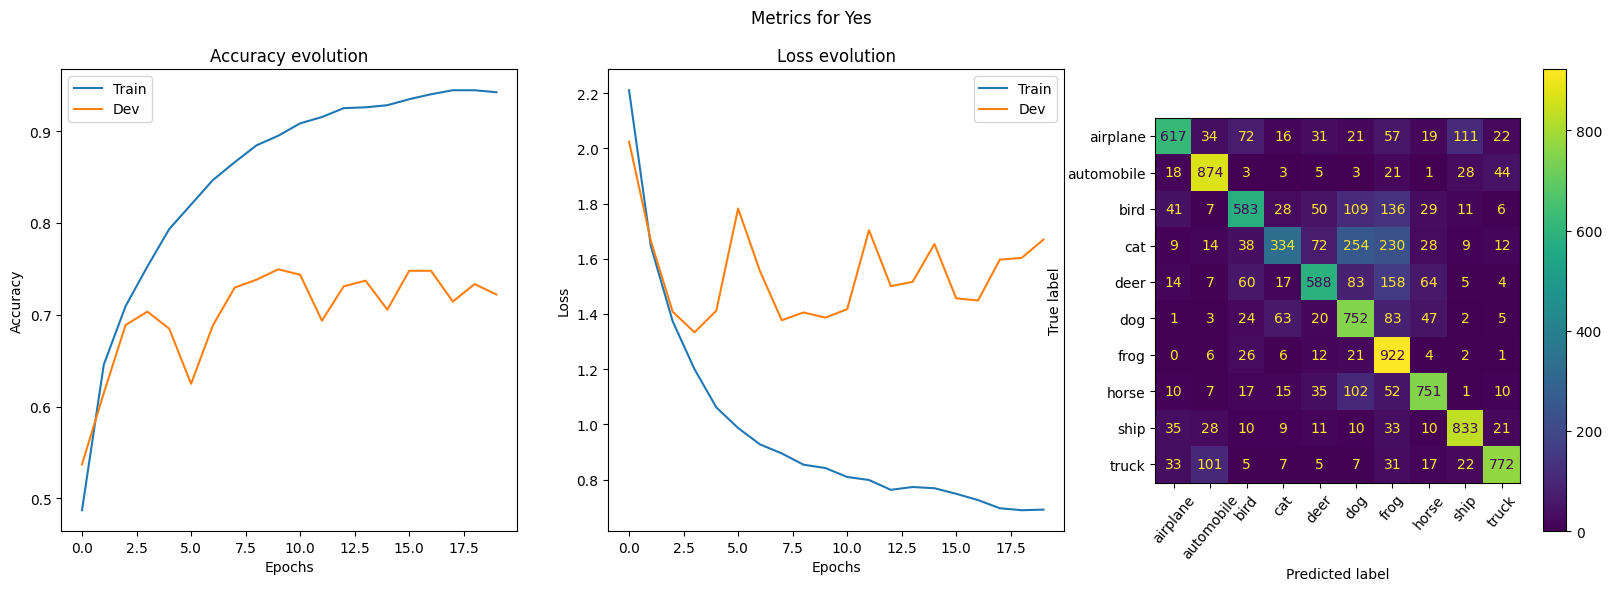

In [11]:
train_loss = history.history['loss'] 
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
acc = {"train": np.array(train_acc).flatten(), "val": np.array(val_acc).flatten()}
losses = {"train": np.array(train_loss).flatten(), "val": np.array(val_loss).flatten()}

print(f"Max acc - train: {np.max(acc['train'])}, val: {np.max(acc['val'])}")
meta = unpickle("../data/batches.meta")
labels = pd.DataFrame({"name": [ i.decode('ascii') for i in meta[b'label_names']], 
            "id": [i for i in range(len(meta[b'label_names']))]})

x_test, y_test = simple_preprocess_xy(unpickle("../data/test_batch"))
y_predicted = model.predict(x_test,verbose=0)
y_predicted =  np.argmax(np.array(y_predicted), axis=1)

display_metrics(acc, losses, y_test, y_predicted, labels['name'])

The followwing is 


Using both confusion matrix, loss/accuracy graph to track improvements

In [19]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import layers
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, log_loss

class MetricLogger(Callback):
    def __init__(self):
        super().__init__()
        self.epoch_loss = []
        self.epoch_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get('loss')
        accuracy = logs.get('accuracy')
        self.epoch_loss.append(loss)
        self.epoch_accuracy.append(accuracy)
        print(f"Epoch {epoch+1}: loss = {loss}, accuracy = {accuracy}")


def create_model(optimizer='adam', init_mode='uniform', activation='relu', loss='sparse_categorical_crossentropy', dropout=0.5, learning_rate=0.01):
        
    input_shape = (32, 32, 3)
    num_classes = 10

    model = tf.keras.Sequential(
        [
            layers.Conv2D(32, (3,3), activation=activation, kernel_initializer=init_mode, input_shape=input_shape),
            layers.MaxPooling2D((2,2)),
            layers.Conv2D(64, (3,3), activation=activation),
            layers.MaxPooling2D((2,2)),
            layers.Conv2D(128, (3,3), activation=activation),
            layers.MaxPooling2D((2,2)),
            layers.Flatten(),
            layers.Dense(128, activation=activation),
            layers.Dropout(dropout),
            layers.Dense(num_classes, activation='softmax')
        ]
    )
    print(optimizer)
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'adadelta':
        optimizer = tf.keras.optimizers.Adadelta(learning_rate=learning_rate)
    elif optimizer == 'rmsprop': 
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Not right optimizer string")

    model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])
    return model

def custom_accuracy(y_true, y_pred):
    return accuracy_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
def custom_loss(y_true, y_pred):
    return log_loss(y_true, y_pred)

model = KerasClassifier(
    model=create_model, 
    optimizer='adam', 
    init_mode='uniform', 
    activation='relu', 
    dropout=0.5, 
    epochs=1, 
    batch_size=2,
    learning_rate=0.1,
    verbose=0
)

scoring = {
    "accuracy": make_scorer(custom_accuracy),
    "loss": make_scorer(custom_loss, greater_is_better=False)
}

param_dist = {
    "optimizer": ['adam', 'rmsprop', 'sgd', 'adadelta'],
    "loss": ["sparse_categorical_crossentropy"], # kullback_leibler_divergence
    "activation": ["relu", "tanh"],
    "init_mode": ["uniform"],
    "dropout": [0.2, 0.4],
    "epochs": [50],  # Adjust as needed
    "batch_size": [128],
    "learning_rate": [0.1, 0.01]  # Adjust as needed
}

testing_grid = {
    "optimizer": ['adam'],
    "loss": ["sparse_categorical_crossentropy"], # kullback_leibler_divergence
    "activation": ["relu"],
    "init_mode": ["uniform"],
    "dropout": [0.2],
    "epochs": [1],  # Adjust as needed
    "batch_size": [2],  # Adjust as needed
    "learning_rate": [0.01, 0.001]
}

grid = GridSearchCV(estimator=model, param_grid=param_dist, scoring='accuracy', n_jobs=-1, cv=3, verbose=2)
metrics_logger = MetricLogger()


batch_X, batch1_y = simple_preprocess_xy(unpickle("../data/data_batch_1")) 
grid_result = grid.fit(np.array(batch_X), np.array(batch1_y), callbacks=[metrics_logger])


Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\Shadow\anaconda3\envs\CIFAR-TF\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


adam
